In [101]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.optim as optim

In [102]:
img = torchvision.io.read_image("images t4\cyber-kitty.jpg")
img = torch.tensor(img, dtype=torch.float)

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\skabh\AppData\Local\Temp\ipykernel_40472\3042914839.py:1: SyntaxWarning: invalid escape sequence '\c'
  img = torchvision.io.read_image("images t4\cyber-kitty.jpg")
C:\Users\skabh\AppData\Local\Temp\ipykernel_40472\3042914839.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float)


In [103]:
def calculate_metrics(original, predicted):
    mse = nn.MSELoss()(original, predicted)
    rmse = torch.sqrt(mse)
    psnr = 20 * torch.log10(1 / rmse)
    return rmse.item(), psnr.item()

In [104]:
def normalize(img):
    return img / 255.0

def denormalize(img):
    return img * 255.0

In [105]:
crop1 = torchvision.transforms.functional.crop(img, 150, 300, 50, 50)

In [106]:
def factorize(A, k, device=torch.device("cpu")):
    A = A.to(device)
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    optimizer = optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    for i in range(1000):
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return W, H, loss

In [107]:
def plot_images(original, reconstructions, ranks):
    num_reconstructions = len(reconstructions)

    rows = num_reconstructions
    fig, axes = plt.subplots(rows, 2, figsize=(12, rows * 4), constrained_layout=True)
    fig.suptitle("Image Reconstruction", fontsize=22)
    
    for i, (reconstructed, r) in enumerate(zip(reconstructions, ranks)):
        axes[i, 0].imshow(original.permute(1, 2, 0).cpu().numpy().astype(np.uint8))
        axes[i, 0].set_title("Original Image", fontsize=16)
        axes[i, 0].axis('off')
        axes[i, 1].imshow(reconstructed.permute(1, 2, 0).cpu().numpy())
        axes[i, 1].set_title(f"Reconstructed Image (rank = {r})", fontsize=16)
        axes[i, 1].axis('off')
    for ax in axes.ravel():
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    plt.subplots_adjust(hspace=0.3)
    plt.show()

(-0.5, 49.5, 49.5, -0.5)

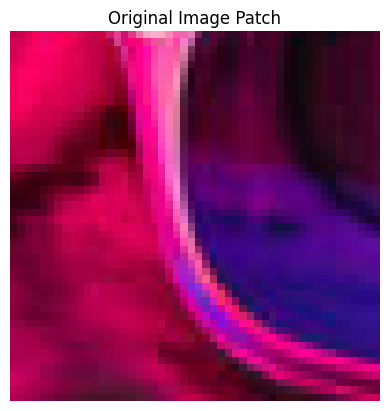

In [108]:
original_patch = img.permute(1, 2, 0).cpu().numpy().astype(np.uint8)[150:200, 300:350]
plt.imshow(original_patch)
plt.title("Original Image Patch")
plt.axis('off')

In [109]:
reconstructions = []
ranks = []
imgs_with_patches_placed = []
original_patch = img.permute(1, 2, 0).cpu().numpy().astype(np.uint8)[150:200, 300:350]
rmse_rank = []
psnr_rank = []

for r in [5, 10, 25, 50]:
    W_red, H_red, loss_red = factorize(crop1[0], r)
    W_green, H_green, loss_green = factorize(crop1[1], r)
    W_blue, H_blue, loss_blue = factorize(crop1[2], r)
    red_reconstructed = torch.mm(W_red, H_red)
    green_reconstructed = torch.mm(W_green, H_green)
    blue_reconstructed = torch.mm(W_blue, H_blue)
    reconstructed_img = torch.stack([red_reconstructed, green_reconstructed, blue_reconstructed], dim=0)
    reconstructed_img = torch.clamp(reconstructed_img, 0, 255)
    reconstructed_img = reconstructed_img.to(torch.uint8)
    rmse_patch, psnr_patch = calculate_metrics(normalize(crop1), normalize(reconstructed_img))

    print("\nMatrix Rank =", r)
    print("The Peak signal to noise ratio is:", psnr_patch)
    print("The Root mean square error is:", rmse_patch)
    print()
    rmse_rank.append(rmse_patch)
    psnr_rank.append(psnr_patch)

    reconstructed_img = reconstructed_img.permute(1, 2, 0).cpu().numpy().astype(np.uint8)
    n_img = img.permute(1, 2, 0).cpu().numpy().astype(np.uint8)

    reconstructions.append(reconstructed_img)

    n_img[150:200, 300:350] = reconstructed_img
    
    imgs_with_patches_placed.append(n_img)

    ranks.append(r)



Matrix Rank = 5
The Peak signal to noise ratio is: 21.32472801208496
The Root mean square error is: 0.08585460484027863


Matrix Rank = 10
The Peak signal to noise ratio is: 27.313261032104492
The Root mean square error is: 0.04308607801795006


Matrix Rank = 25
The Peak signal to noise ratio is: 47.22657775878906
The Root mean square error is: 0.004351822193711996


Matrix Rank = 50
The Peak signal to noise ratio is: 51.194705963134766
The Root mean square error is: 0.0027559075970202684



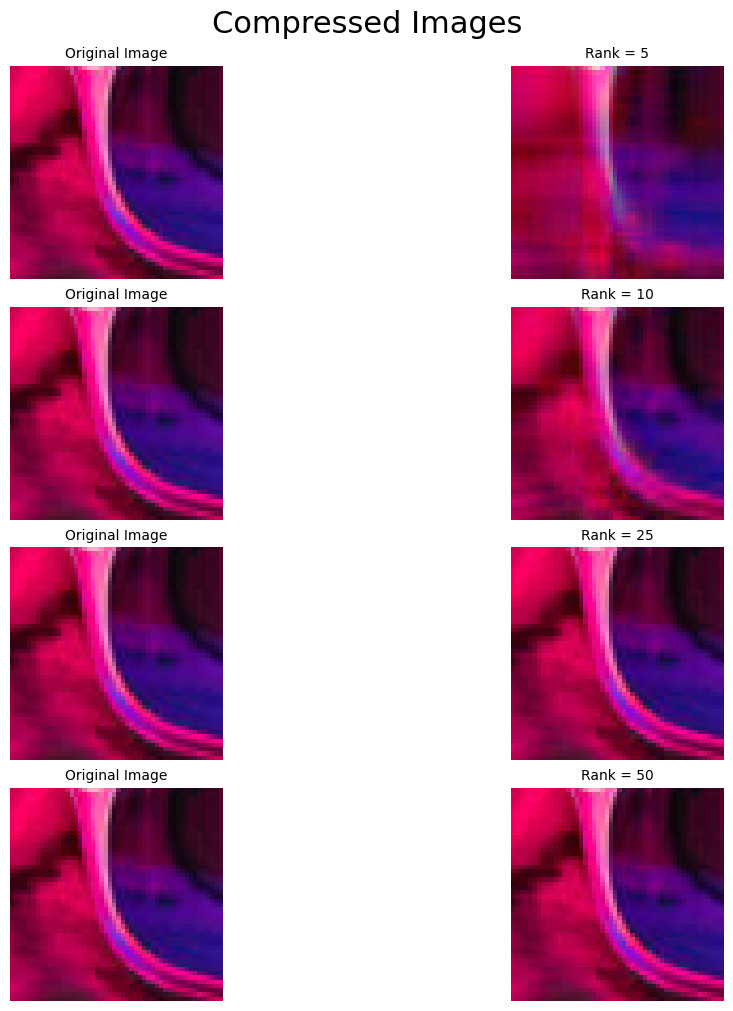

In [110]:

fig, axes = plt.subplots(4, 2, figsize=(10, 10), constrained_layout=True)
fig.suptitle("Compressed Images", fontsize=22)

for i, (reconstructed, r) in enumerate(zip(reconstructions, ranks)):
    axes[i, 0].imshow(original_patch)
    axes[i, 0].set_title("Original Image", fontsize=10)
    axes[i, 0].axis('off')
    axes[i, 1].imshow(reconstructed)
    axes[i, 1].set_title(f"Rank = {r}", fontsize=10)
    axes[i, 1].axis('off')

plt.show()


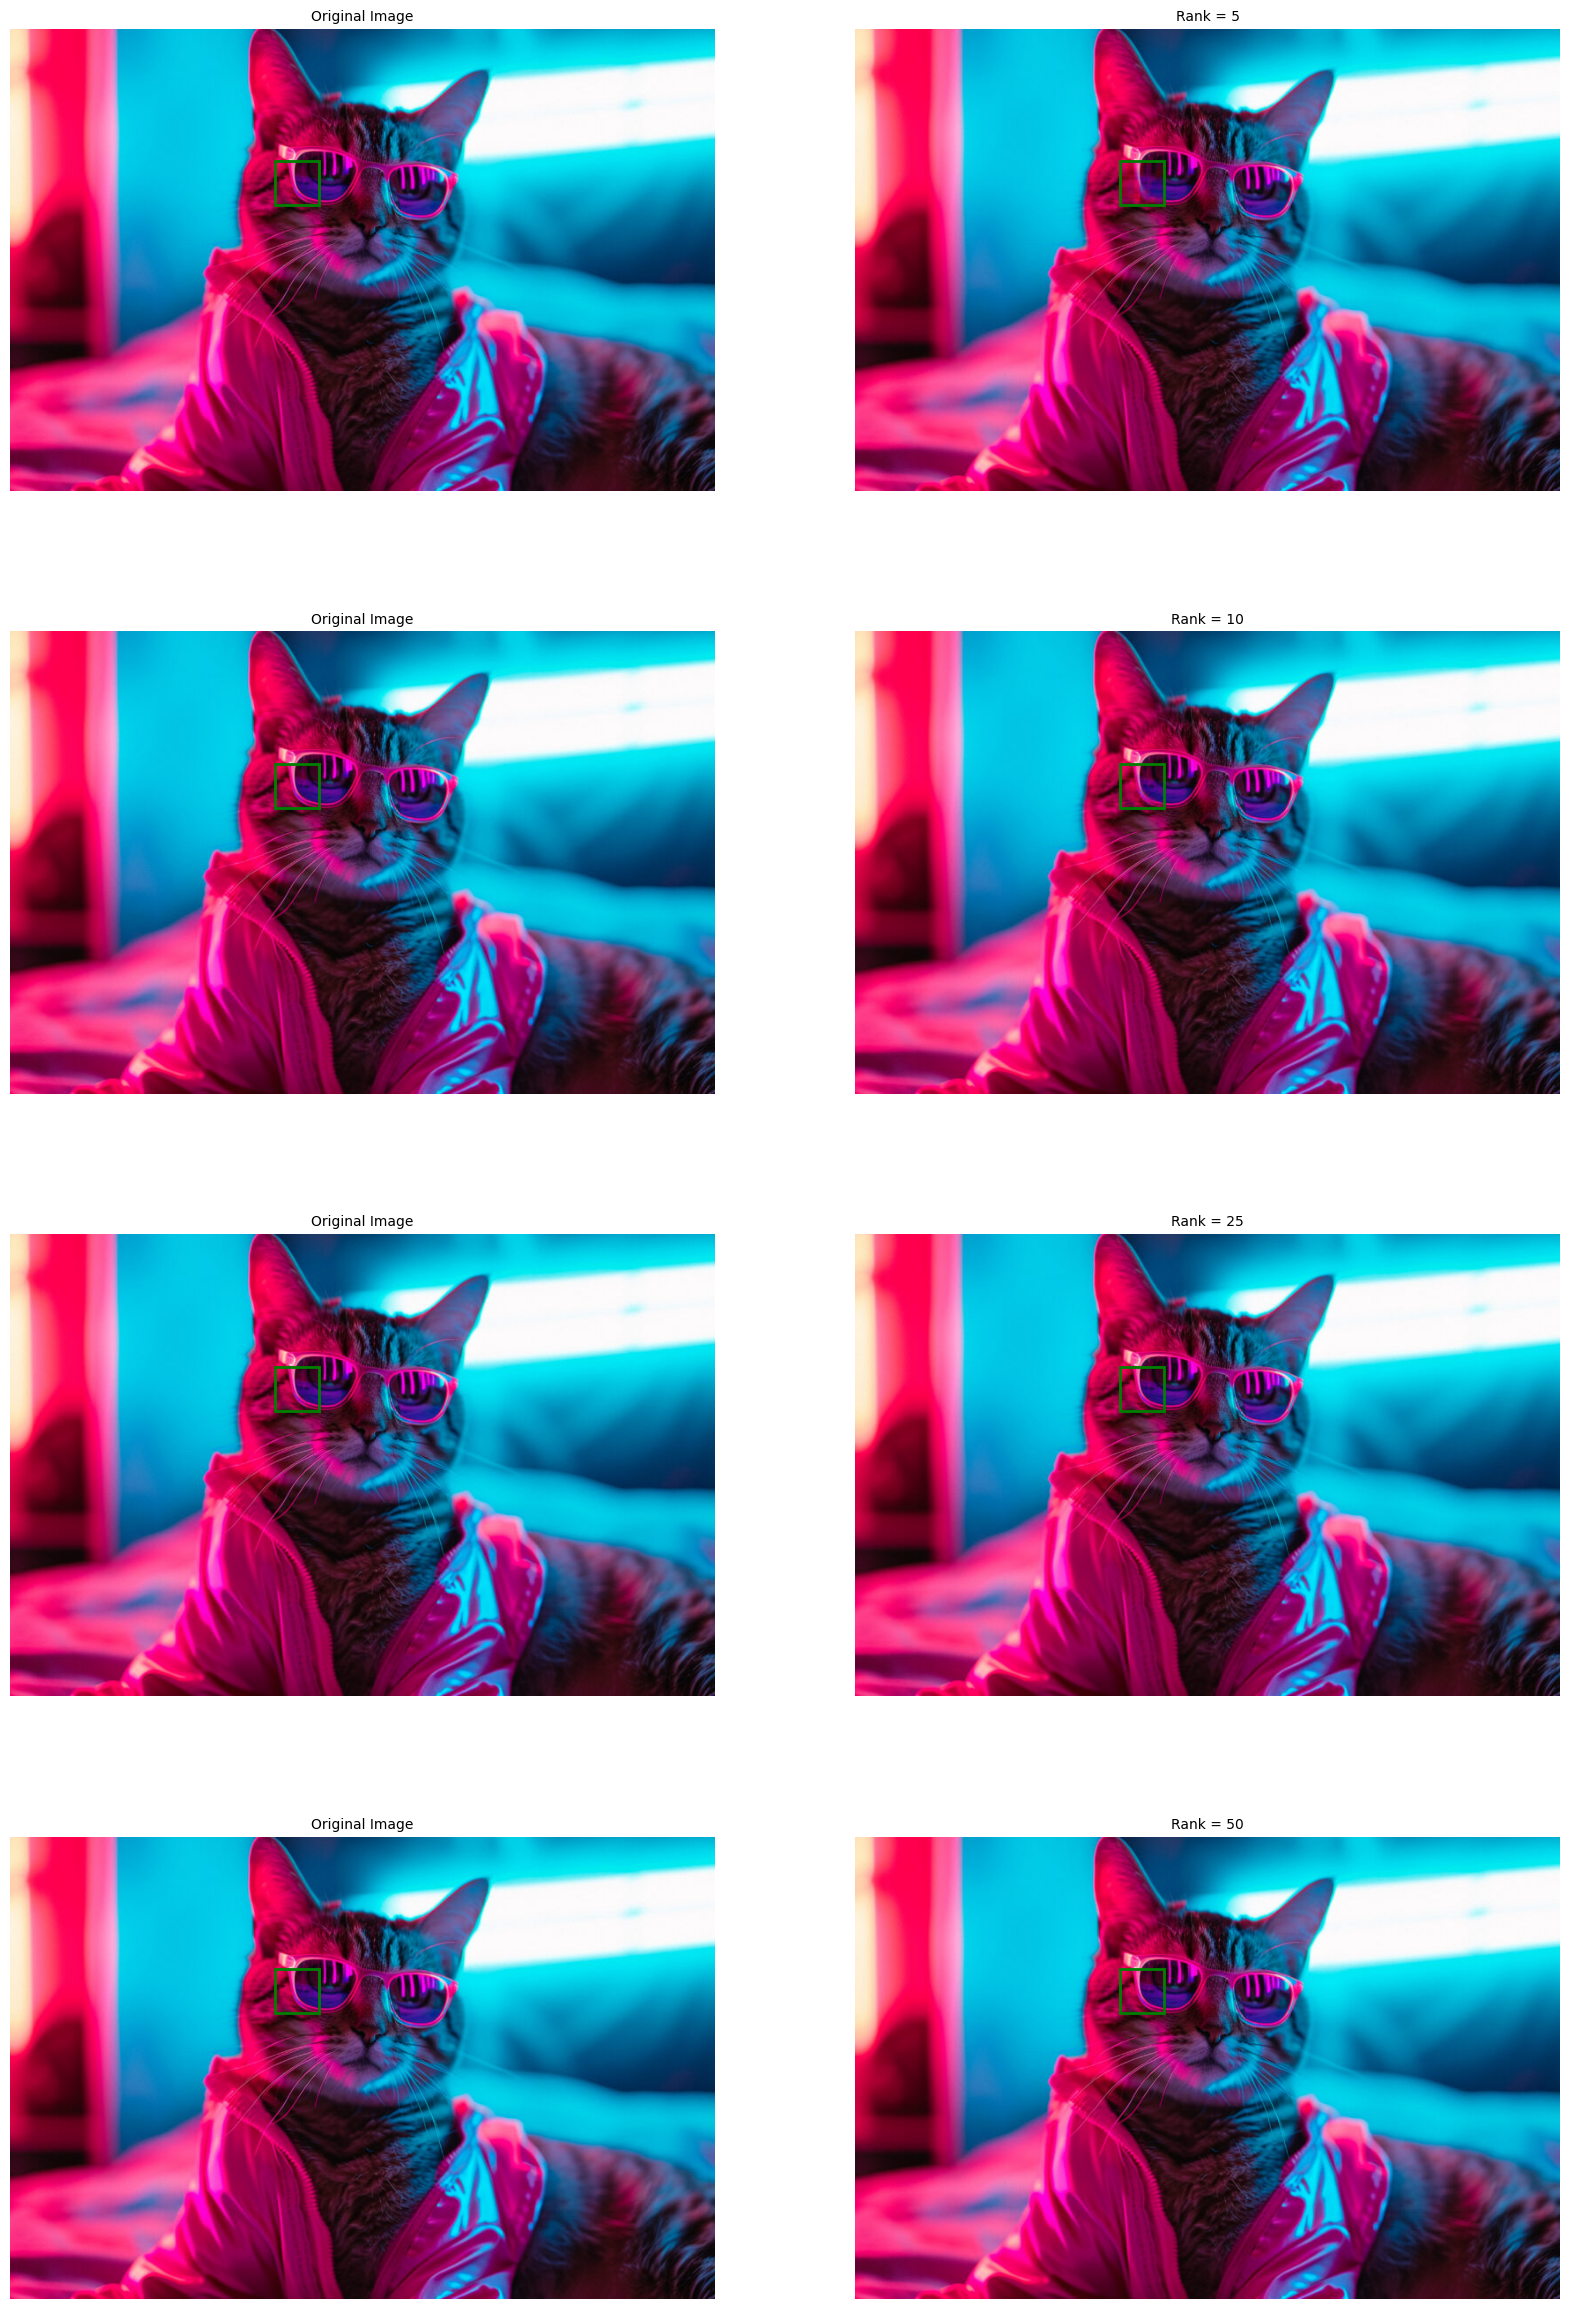

In [111]:
fig, axes = plt.subplots(4, 2, figsize=(20, 30))

for i in range(4):
    axes[i, 0].imshow(img.permute(1, 2, 0).cpu().numpy().astype(np.uint8))
    axes[i, 0].add_patch(plt.Rectangle((300, 150), 50, 50, fill=False, edgecolor='green', lw=2))
    axes[i, 0].set_title("Original Image", fontsize=10)
    axes[i, 0].axis('off')
    axes[i, 1].imshow(img.permute(1, 2, 0).cpu().numpy().astype(np.uint8))
    axes[i, 1].add_patch(plt.Rectangle((300, 150), 50, 50, fill=False, edgecolor='green', lw=2))
    axes[i, 1].set_title("Original Image", fontsize=10)
    axes[i, 1].axis('off')
for i, j in enumerate(imgs_with_patches_placed):
    axes[i, 1].imshow(j)
    axes[i, 1].set_title(f"Rank = {ranks[i]}", fontsize=10)
    axes[i, 1].axis('off')

plt.show()

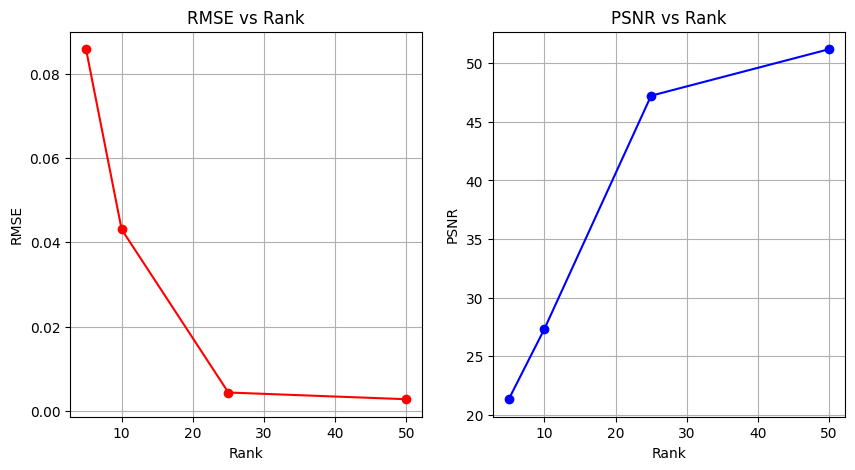

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(ranks, rmse_rank, color = "red", marker = "o")
axes[0].set_title("RMSE vs Rank")
axes[0].set_xlabel("Rank")
axes[0].set_ylabel("RMSE")
axes[0].grid()

axes[1].plot(ranks, psnr_rank, color = "blue", marker = "o")
axes[1].set_title("PSNR vs Rank")
axes[1].set_xlabel("Rank")
axes[1].set_ylabel("PSNR")
axes[1].grid()